In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as pp
import numpy as np
import csv
import os

import time
import sys

from matplotlib import cm
from numpy import arctan, log, pi, sqrt


%matplotlib notebook

os.chdir("D:")

# Mesh Generation:

In [2]:
nx  = 60
ny  = 60
nt  = 100

xmin = -5
xmax = 5
ymin = 0
ymax = 10

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dt = 1e-4

x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(ymin, ymax, ny)

X, Y = np.meshgrid(x, y)

L = ymax

aa = int(nx/2) #this is x range because it is half in negetive and half in positive part
roundNum = 6 #round for answers

# Creating fields for equation parameters:

In [3]:
u  = np.zeros((ny, nx))
un = np.zeros((ny, nx))

v  = np.zeros((ny, nx))
# vn = np.zeros((ny, nx))

T  = np.zeros((ny, nx))
Tn = np.zeros((ny, nx))

C  = np.zeros((ny, nx))
Cn = np.zeros((ny, nx))

H  = np.zeros((ny, nx))
Hx = np.zeros((ny, nx))
Hy = np.zeros((ny, nx))

# Fluid Specs:

In [4]:
mu  = 0.001
rho = 997.5
nu  = mu/rho #0.801e-6
Cp  = 4178
Cv  = 4.15
tau = Cp/Cv
kf  = 0.6129 #heat transfer coeff. fluid
kp  = 80.4   #heat transfer coeff. particle

# Flow Specs:

In [5]:
a      = 0.06
beta   = 0.001 #unsteadiness paramepter
mu0    = 4e-7*pi
M      = 8.6e5
h      = 12.5e-6   #height of magnet
w      = 25e-6     #width of magnet
eps    = 0.1
Q0     = 30 #heat generation
H0     = 253843.822358745
alpha = 0.143e-6  #thermal diffusivity

In [6]:
V0    = -0.04
ts    = nt*dt #Final time

Cf    = 0.2/100
Cinf  = 0.4/100

Tinf  = 350 #333
Tf    = 300 #initial Temp

delT  = Tf - Tinf
delC  = Cf - Cinf

Tpp = (Tf + Tinf)/delT
Cpp = (Cf + Cinf)/delC

Pr    = nu/alpha
Re    = abs(V0*L/nu)
Sc    = 5

Nu = abs(0.332 * (Re**(1/2)) * (Pr**(1/3)))
Sh = abs(0.332 * (Re**(1/2)) * (Sc**(1/3)))

# Nu    = 0.2497091666
# Sh    = 0.922369

# print("Re = {}".format(Re))

In [7]:
kB = 1.385e-23
dp = 1e-8 #particle diameter
TF = (Tinf + Tf)/2 #Film temperature
DB = (kB*TF)/(3 * pi * mu * dp) #Brownian motion coeff.
DT = (mu/rho) * (0.26 * kf/(kf + kp)) #Thmoforesis coeff

In [8]:
# u.fill(a*L/V0) 
# v.fill(V0)
# T.fill(Tf)
# C.fill(Cf)

# Calculating magnitization intensity (H):

In [9]:
def Hcalc(i, j):
    H = (sqrt(M**2*(-log(((-h + j)**2 +
                          (-w + i)**2)/((h + j)**2 +
                          (-w + i)**2)) +
                          log(((-h + j)**2 + (w + i)**2)/((h + j)**2 +
                          (w + i)**2)))**2/(16*pi**2) +
                          M**2*(-arctan(2*h*(-w + i)/(-h**2 + j**2 +
                          (-w + i)**2)) + arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2)))**2/(4*pi**2)))
    H = H/H0
    return H

# Derivative of H: $\frac{\partial H}{\partial x}$ or $\frac{\partial H}{\partial y}$

In [10]:
def Hdiff(i, j, d, var):
    if (var == "x"):
        dH = (Hcalc(i+1, j) - Hcalc(i, j))/d
    elif (var == "y"):
        dH = (Hcalc(i, j+1) - Hcalc(i, j))/d
    return dH

In [11]:
for i in range(-aa, aa+1):
    for  j in range(ny):
        H[j, i] = Hcalc(i, j)
        Hx[j, i] = Hdiff(i, j, dx, "x")
        Hy[j, i] = Hdiff(i, j, dy, "y")

# 1st Derivative: $\frac{\partial F}{\partial x}$ or $\frac{\partial F}{\partial y}$

In [12]:
def diff1(i, j, F, d, var):
    if (var == "x"):
        dF = (F[j, i+1] - F[j, i-1])/(2*d)
    elif (var == "y"):
        dF = (F[j+1, i] - F[j-1, i])/(2*d)
    return dF

# 2nd Derivative: $\frac{\partial^2 F}{\partial x^2}$ or $\frac{\partial^2 F}{\partial y^2}$

In [13]:
def diff2(i, j, F, d, var): #derivative 2
    if (var == "x"):
        d2F = (F[j, i+1] - 2*F[j, i] + F[j, i-1])/(2*d)
    elif (var == "y"):
        d2F = (F[j+1, i] - 2*F[j, i] + F[j-1, i])/(2*d)
    return d2F

# 1st Diff:

In [14]:
def d1ux():
    d = (un[1:-1, 2:] - un[1:-1, 0:-2])/(2*dx)
    return d

def d1uy():
    d = (un[2:, 1:-1] - un[0:-2, 1:-1])/(2*dy)
    return d

def d1Tx():
    d = (Tn[1:-1, 2:] - Tn[1:-1, 0:-2])/(2*dx)
    return d

def d1Ty():
    d = (Tn[2:, 1:-1] - Tn[0:-2, 1:-1])/(2*dy)
    return d

def d1Cx():
    d = (Cn[1:-1, 2:] - Cn[1:-1, 0:-2])/(2*dx)
    return d

def d1Cy():
    d = (Cn[2:, 1:-1] - Cn[0:-2, 1:-1])/(2*dy)
    return d

# 2nd Diff:

In [15]:
def d2ux():
    d = (un[1:-1, 2:] - 2*un[1:-1, 1:-1] + un[1:-1, 0:-2])/(2*dx)
    return d

def d2uy():
    d = (un[2:, 1:-1] - 2*un[1:-1, 1:-1] + un[0:-2, 1:-1])/(2*dy)
    return d

def d2Tx():
    d = (Tn[1:-1, 2:] - 2*Tn[1:-1, 1:-1] + Tn[1:-1, 0:-2])/(2*dx)
    return d

def d2Ty():
    d = (Tn[2:, 1:-1] - 2*Tn[1:-1, 1:-1] + Tn[0:-2, 1:-1])/(2*dy)
    return d

def d2Cx():
    d = (Cn[1:-1, 2:] - 2*Cn[1:-1, 1:-1] + Cn[1:-1, 0:-2])/(2*dx)
    return d

def d2Cy():
    d = (Cn[2:, 1:-1] - 2*Cn[1:-1, 1:-1] + Cn[0:-2, 1:-1])/(2*dy)
    return d

# Calculate U field:

In [16]:
def uCalc(t, u, v, un):
    un = u.copy()
    
    #Boundary Condition:
    v[-1, :] = 0 #y = oo
    v[0, :] = -1/(V0 * (1 - beta*ts*t)) #y = 0
    #
    #
    for i in range(-aa, aa+1):
        u[0, i]  = (a*L*i)/(V0 * (1 - beta*ts*t)) #y = 0
        u[-1, i] = (a*L*i)/(V0 * (1 - beta*ts*t)) #y = oo
    #
    #
    for i in range(-aa+1, aa-1):
        for j in range(1, ny-1):
            u[j, i] = (((ts*dt)/V0) * ((a*L*i*(a+beta))/(1-beta*ts*t) + 
                           ((nu*V0)/(L**2)) * diff2(i, j, un, dy, "y") +
                           ((1/rho)*mu0*M*H0/L) * Hdiff(i, j, dx, "x") -
                           (((V0**2)/L) * un[j, i] * diff1(i, j, un, dx, "x") +
                           (((V0**2)/L) * v[j, i] * diff1(i, j, un, dy, "y"))) +
                           un[j, i]))
            
    u = u.round(roundNum)
    v = v.round(roundNum)
    un = un.round(roundNum)
    return (u, v, un)

# Calculate T field:

In [17]:
def TCalc(T, Tn):
    Tn = T.copy()
    T[1:-1, 1:-1] = (((ts*dt)/delT) * (tau *
                             ((DB/(L**2)) * delC * (delT) * d1Cy() * d1Ty()) + 
                             (DT/(Tinf * (L**2))) * (delT**2) * (d1Ty()**2)) + 
                             (Q0/(rho*Cp)) * delT * (Tn[1:-1, 1:-1]) +
                             ((alpha * delT)/L) * d2Ty() - 
                             ((V0/L) * un[1:-1, 1:-1] * delT * d1Tx() + 
                             (V0/L) * v[i, j] * delT * d1Ty())
                              + Tn[1:-1, 1:-1])
    #Boundary Condition:
    T[0, :]  = (T[1, :] + (dy*Nu*Tpp))/(1 + dy*Nu) #y = 0
    T[-1, :] = -1                      #y = oo
    
    T = T.round(roundNum)
    Tn = Tn.round(roundNum)
    return (T, Tn)

# Calculate C field

In [18]:
def CCalc(C, Cn):
    Cn = C.copy()
    C[1:-1, 1:-1] = (((ts*dt)/delC) * ((DB/(L**2)) * delC * d2Cy() +
                        (DT/((L**2)*Tinf)) * delT * d1Ty() - 
                        ((V0/L) * un[1:-1, 1:-1] * delC * d1Cx() + 
                        (V0/L) * v[1:-1, 1:-1] * delC * d1Cy())) +
                         Cn[1:-1, 1:-1])
    #Boundary Condition:
    C[0, :]  = (C[1, :] + (dy*Sh*Cpp))/(1 + dy*Sh) #y = 0
    C[-1, :] = -1                      #y = oo
    
    C = C.round(roundNum)
    Cn = Cn.round(roundNum)
    return (C, Cn)

# Solver prepration:

In [19]:
udiff     = 1
Tdiff     = 1
Cdiff     = 1
accu      = 0.001

iteration = np.zeros((nt, 1))

udiffDat = np.zeros((nt, 1))
TdiffDat = np.zeros((nt, 1))
CdiffDat = np.zeros((nt, 1))
CORD     = np.zeros((nt, 1))

# FHD Solver:

In [20]:
stepcount = 0

for t in range(nt):     
    (u, v, un) = uCalc(t, u, v, un)
    (T, Tn) = TCalc(T, Tn)
    (C, Cn) = CCalc(C, Cn)
        
    udiff = (np.sum(u) - np.sum(un))/np.sum(u)
    Tdiff = (np.sum(T) - np.sum(Tn))/np.sum(T)
    Cdiff = (np.sum(C) - np.sum(Cn))/np.sum(C)
    
    udiff = round(udiff, roundNum)
    Tdiff = round(Tdiff, roundNum)
    Cdiff = round(Cdiff, roundNum)
    
    COR = (u*dt)/dx
    COR = COR.max()
    COR = round(COR, roundNum)
        
    udiffDat[t] = udiff
    TdiffDat[t] = Tdiff
    CdiffDat[t] = Cdiff
    CORD[t]     = COR
    iteration[t] = stepcount
    stepcount += 1
    
    print("Iteration number: " + str(stepcount) + " | Courant Number: " + str(COR) + "\n")
    print("X_Velocity: " + str(udiff) 
          + " | " + "Temperature: " + str(Tdiff) 
          + " | " + "Concentration: " + str(Cdiff) + "\n")
    print("---------------------------------------------------------------------------\n")
    
#     if (udiff > 1.2) or (Tdiff > 1.2) or (Cdiff > 1.2):
#         break

#     if stepcount == STEP:
#         print("Calculation is finished!")
#         break

Iteration number: 1 | Courant Number: 0.25665

X_Velocity: 1.0 | Temperature: 1.0 | Concentration: 1.0

---------------------------------------------------------------------------

Iteration number: 2 | Courant Number: 0.256653

X_Velocity: 1e-05 | Temperature: -0.0 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 3 | Courant Number: 0.256655

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 4 | Courant Number: 0.256658

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 5 | Courant Number: 0.25666

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 6 | Courant Number: 0.256663

X_Velocity: 1e-05 | Te

Iteration number: 45 | Courant Number: 0.256763

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 46 | Courant Number: 0.256766

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 47 | Courant Number: 0.256768

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 48 | Courant Number: 0.256771

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 49 | Courant Number: 0.256773

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 50 | Courant Number: 0.256776

X_Velo

Iteration number: 89 | Courant Number: 0.256876

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 90 | Courant Number: 0.256879

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 91 | Courant Number: 0.256881

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 92 | Courant Number: 0.256884

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 93 | Courant Number: 0.256886

X_Velocity: 1e-05 | Temperature: -2e-06 | Concentration: -0.0

---------------------------------------------------------------------------

Iteration number: 94 | Courant Number: 0.256889

X_Velo

# Residuals:

<IPython.core.display.Javascript object>


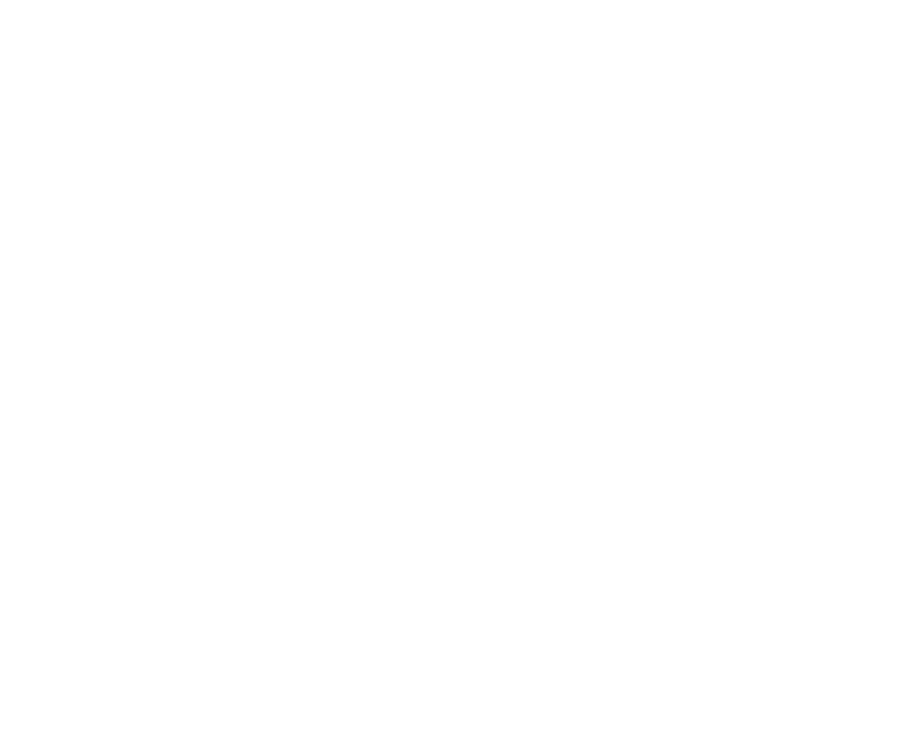

In [21]:
%matplotlib notebook

pp.figure()

pp.autoscale(enable=True, axis='x', tight=True)

pp.plot(iteration, udiffDat, label = "X_Velocity", color = 'r')
pp.plot(iteration, TdiffDat, label = "Temperature", color = 'green')
pp.plot(iteration, CdiffDat, label = "Concentration", color = 'blue')
# pp.plot(iteration, CORD, label = "Courant Number")

# pp.grid(True)
pp.legend();
pp.xlabel("Iterations")
pp.ylabel("Residuals")

pp.grid(True)

pp.tight_layout()
fig = pp.gcf()
fig.set_size_inches(6, 5)

# Contours:

<IPython.core.display.Javascript object>


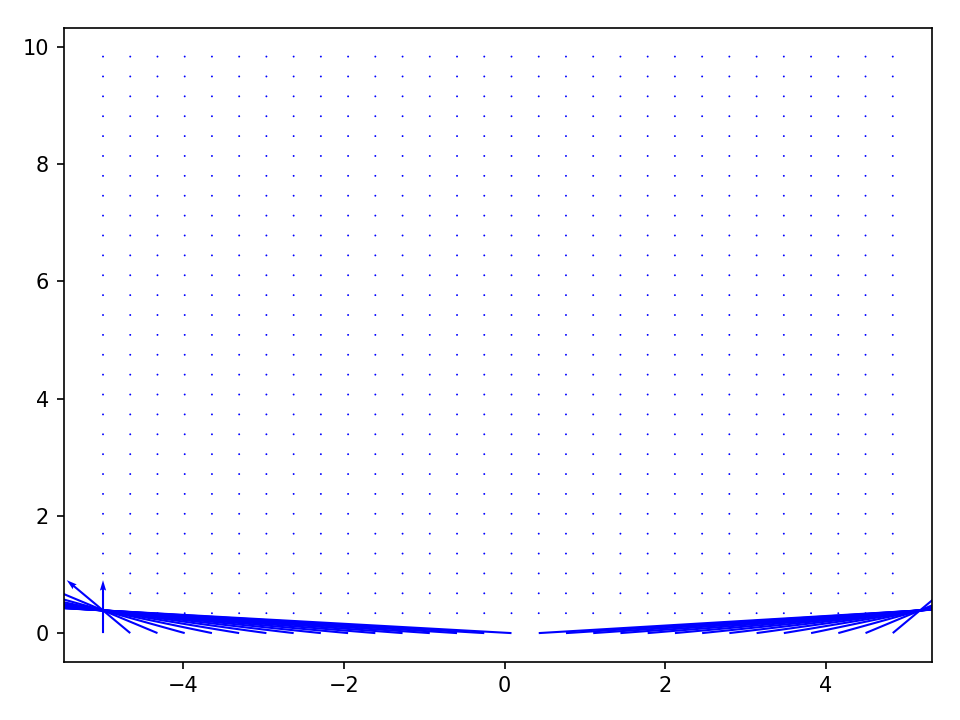

In [34]:
%matplotlib notebook
pp.figure()
z = 2
pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z], color = "blue");
pp.tight_layout()

# Contour Plot Function :

In [23]:
def CPlot(F, title):
    %matplotlib notebook
    fig = pp.figure()
    contour_res = 100
    #
    pp.contourf(X, Y, F, contour_res, cmap = "seismic")  
    pp.colorbar()
    #
    # pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]) 
    pp.xlabel('X')
    pp.ylabel('Y')
    #
    fig = pp.gcf()
    fig.set_size_inches(6, 5)
    pp.title(title)

<IPython.core.display.Javascript object>


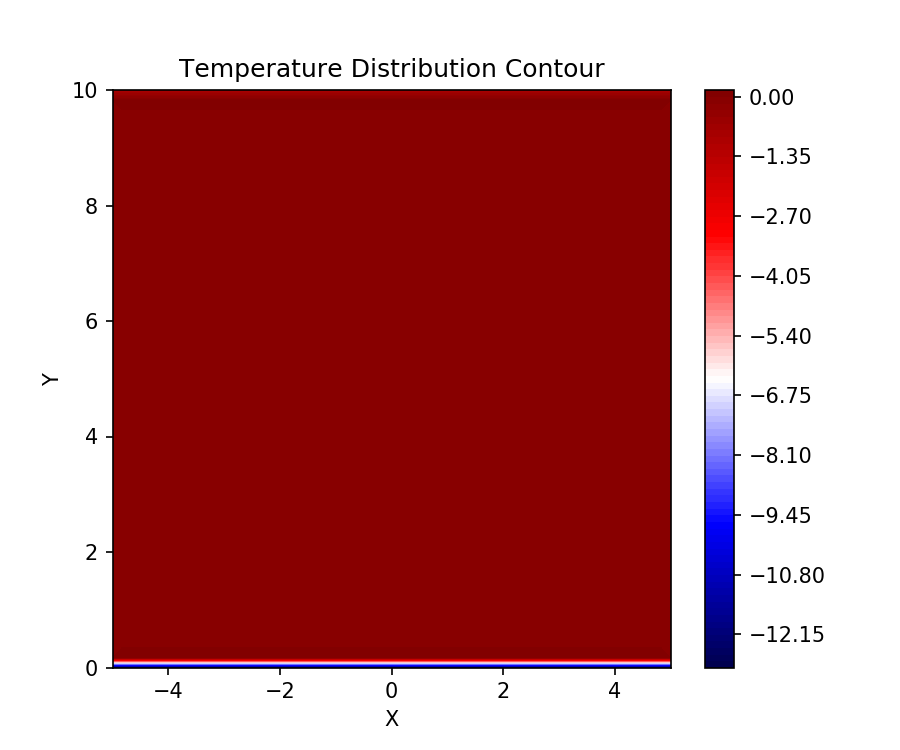

In [28]:
CPlot(T, "Temperature Distribution Contour")

<IPython.core.display.Javascript object>


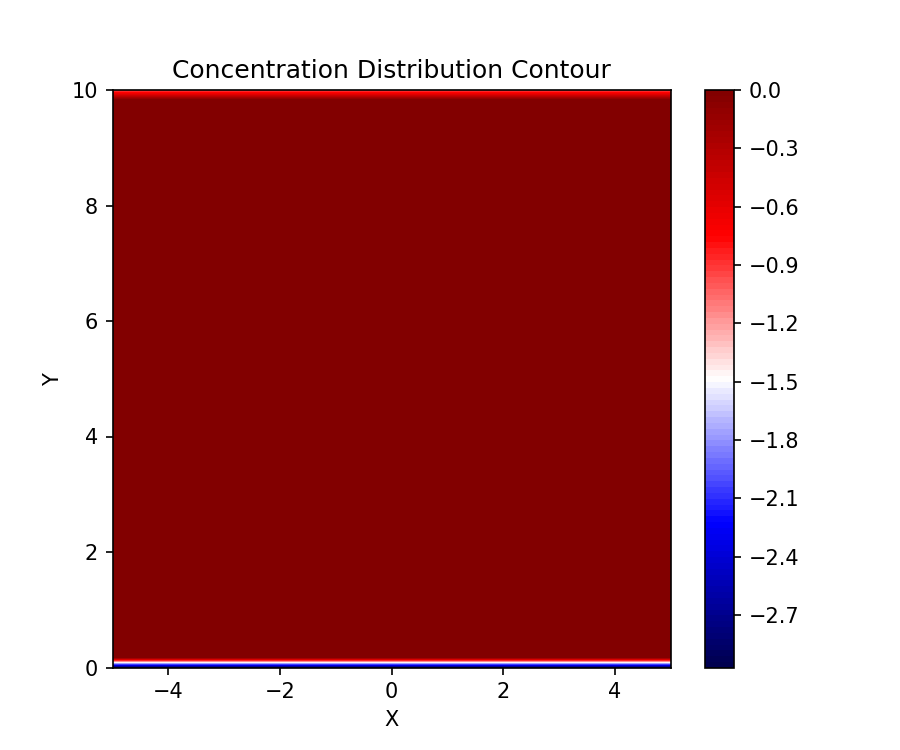

In [25]:
CPlot(C, "Concentration Distribution Contour")

<IPython.core.display.Javascript object>


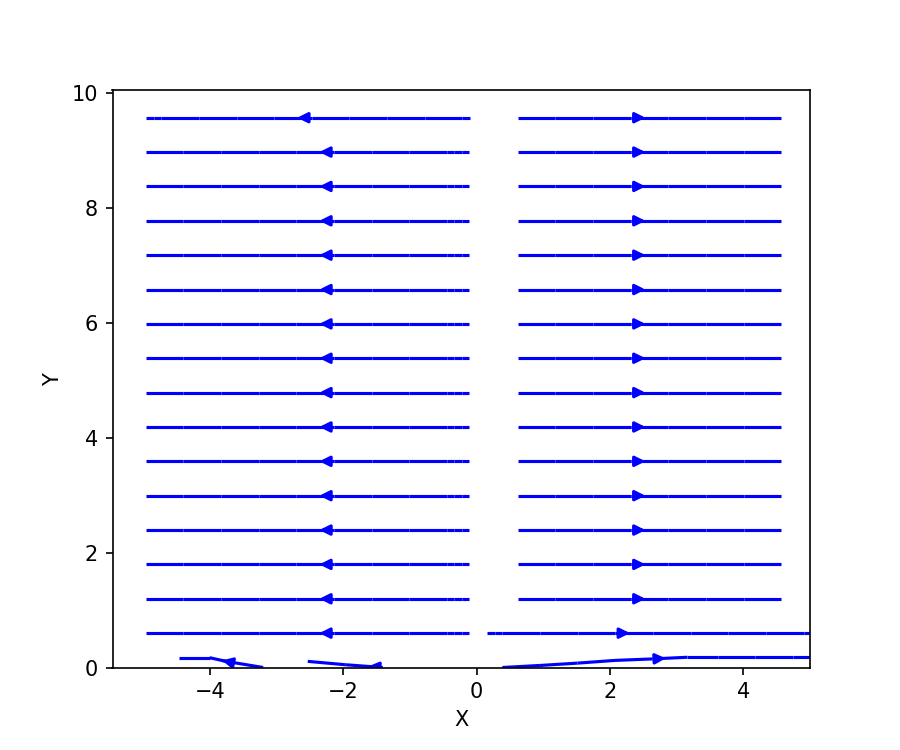

In [26]:
fig = pp.figure(figsize=(11, 7), dpi=100)

pp.streamplot(X, Y, u, v, color='b', linewidth=1.5, density=0.6)
pp.xlabel('X')
pp.ylabel('Y');
fig = pp.gcf()
fig.set_size_inches(6, 5)

In [33]:
T.min()

-12.811671